## Requirements

```
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
pip install pandas matplotlib transformers pillow wandb scikit-learn
```


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import glob
import numpy as np
import wandb
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch import nn
from torchvision import transforms
from sklearn.model_selection import train_test_split

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ["TRANSFORMERS_CACHE"] = "data/models"
# check cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# Initialize the model and processor
models = {
        "base": "openai/clip-vit-base-patch32",
        "large": "openai/clip-vit-large-patch14"
}
model_name = models["base"]
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

In [4]:
# load recipes data
recipes = pd.read_csv("data/chefkoch22k/ingredients_with_titles.csv")
recipes.head()

,RecipID,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,RecipeTitle
0,6971800010,Cachaça,Zucker,Limette,Eis,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Caipirinha
1,7971878818,Wodka,Gin,Rum,Likör,Ananassaft,Grapefruitsaft,Zitronensaft,Grenadine,Guaranapulver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pangalaktischer Donnergurgler
2,23973004603,Petersilie,Chilischote,Knoblauchzehe,Garnele,Olivenöl,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tapas-Garnelen in Knoblauchöl
3,43974876764,Schweinefilet,Möhre,Sellerie,Lauch,Brokkoli,Mostbröckli,Käse Appenzeller,Sauerhalbrahm,Weißwein,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appenzeller Filet
4,48974889052,Kaninchen,Butter,Fleischbrühe,Zwiebel,Möhre,Tomate,Speck,Salz,Pfeffer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bauernkaninchen


In [5]:
# load images
n_images = -1  # -1 for all images
image_directory = "data/chefkoch22k/chefkoch22k_pictures"

# Function to find image path
def find_image_path(recip_id):
    image_path = glob.glob(f"{image_directory}/*/{recip_id}.jpg")
    return image_path[0] if image_path else None

# Find image path for each recipe and filter out recipes without images
# recipes['image_path'] = recipes['RecipID'].apply(find_image_path)
# recipes = recipes[recipes['image_path'].notnull()]

# Or load the data with image paths
recipes = pd.read_csv("data/chefkoch22k/recipes_with_image_paths.csv")

# save the data with image paths (if not already saved)
# recipes.to_csv("data/chefkoch22k/recipes_with_image_paths.csv", index=False)

### Zero-Shot Prediction

Title: Caipirinha
- Cachaça
- Zucker
- Limette
- Eis


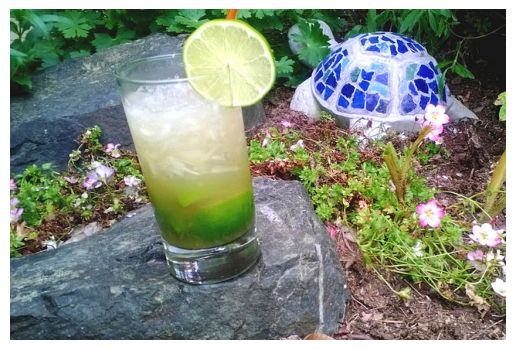

In [6]:
# example recipe with image
n = 0
def print_recipe(n):
    print(f"Title: {recipes.loc[n, 'RecipeTitle']}")
    for i in range(1, 46):
        ingredient = recipes.loc[n, f"{i}"]
        if pd.isna(ingredient):
            break
        print(f"- {ingredient}")
    image = Image.open(recipes.loc[n, 'image_path'])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.imshow(image)
    plt.show()

print_recipe(n)

In [7]:
# create list of individual ingredients
ingredients = []
for i in range(1, 46):
    ingredient = recipes[f"{i}"].dropna().tolist()
    ingredients.extend(ingredient)

# remove duplicates
ingredients = list(set(ingredients))
# sort alphabetically
ingredients.sort()

print(f"Number of unique ingredients: {len(ingredients)}")
print(ingredients)

Number of unique ingredients: 3341
['Aal', 'Aceto', 'Adzukibohne', 'Agar', 'Agartine', 'Agavendicksaft', 'Agavensirup', 'Ahornsirup', 'Aioli', 'Ajvar', 'Akazienhonig', 'Aktivkohlepulver', 'Alge', 'Alkohol', 'Altbier', 'Altbrot', 'Alufolie', 'Amarant', 'Amarenakirsch', 'Amarenakirsche', 'Amaretti', 'Amarettini', 'Amaretto', 'Anana', 'Ananas', 'Ananas Stück', 'Ananaskonfitüre', 'Ananassaft', 'Ananasscheibe', 'Ananasstück', 'Anbraten', 'Anchovi', 'Anchovis', 'Anchovisfilet', 'Andünsten', 'Anelletti', 'Angostura', 'Angus', 'Ani', 'Anis', 'Anispulver', 'Anissame', 'Anisschnaps', 'Anstellgut', 'Aperitifwein', 'Aperol', 'Apfel', 'Apfel Boskoop', 'Apfelchips', 'Apfeldicksaft', 'Apfelessig', 'Apfelgelee', 'Apfelkompott', 'Apfelkraut', 'Apfelmost', 'Apfelmus', 'Apfelsaft', 'Apfelschorle', 'Apfelsine', 'Apfelwein', 'Apotheke', 'Appenzeller', 'Aprikose', 'Aprikose Marille', 'Aprikosengelee', 'Aprikosenkonfitür', 'Aprikosenkonfitüre', 'Aprikosenlikör', 'Aprikosenmarmelade', 'Aprikosensaft', 'Apriko

In [8]:
# find similarities between image and ingredients
def similarities_ingredients_to_image(image, ingredients):
    inputs = processor(text=ingredients, images=[image], return_tensors="pt", padding=True)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits_per_text

# get similarities for example recipe
image = Image.open(recipes.loc[n, 'image_path'])
ingredients_logits = similarities_ingredients_to_image(image, ingredients)

In [9]:

# create dataframe with similarities
image_similarity = pd.DataFrame(ingredients_logits.cpu().detach().numpy(), index=ingredients, columns=["similarity"])
image_similarity = image_similarity.sort_values(by="similarity", ascending=False)
print(image_similarity.head(-1))
actual_ingredients_similarity = image_similarity[image_similarity.index.isin(recipes.loc[n, "1":"45"].dropna().tolist())]
actual_ingredients_similarity = actual_ingredients_similarity.sort_values(by="similarity", ascending=False)
actual_ingredients_similarity.head(20)

                  similarity
Kokosblütensirup   27.701260
Limettensirup      27.245743
Cocktailfrüchte    27.029333
Kokosdrink         26.948536
Karamellsirup      26.926064
...                      ...
Salami             14.585800
Bresaola           14.304532
Sepia              13.248146
Waffel             13.104164
Momo               11.453280

[3340 rows x 1 columns]


,similarity
Limette,23.819319
Cachaça,23.305410
Eis,21.179989
Zucker,20.033390


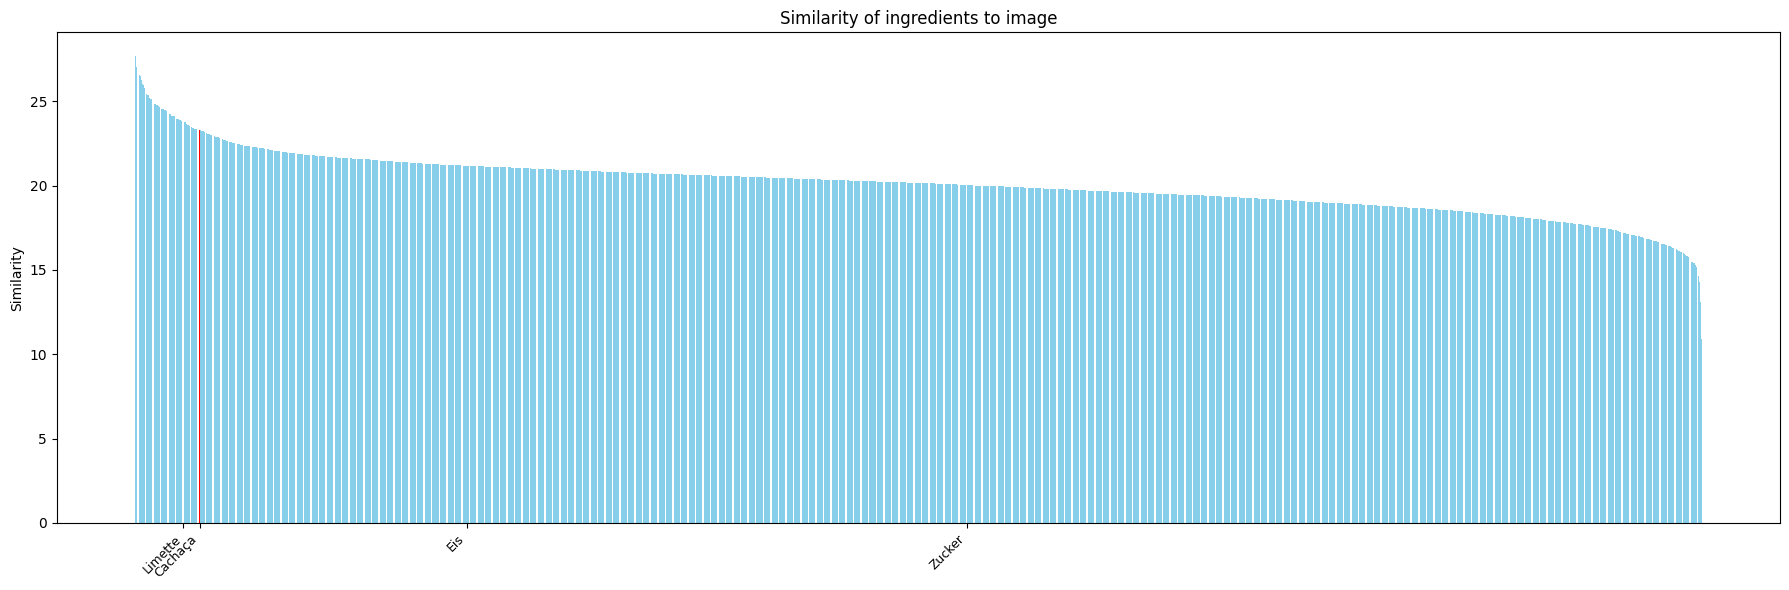

In [10]:
# plot similarities (with actual ingredients highlighted) bar plot
plt.figure(figsize=(18, 6))
plt.bar(image_similarity.index, image_similarity["similarity"], color="skyblue")
plt.bar(actual_ingredients_similarity.index, actual_ingredients_similarity["similarity"], color="red")
plt.xticks(actual_ingredients_similarity.index, rotation=45, ha="right", fontsize=9)
plt.ylabel("Similarity")
plt.title("Similarity of ingredients to image")
plt.tight_layout()
plt.show()

In [11]:
def create_ingredient_prompt(ingredients):
    # Format the ingredient list into a single prompt string
    if ingredients:
        return f"A photo of a dish made with " + ", ".join(ingredients[:-1]) + f", and {ingredients[-1]}."
    else:
        return "A photo of a dish."

def evaluate_ingredient_image(image, ingredients, processor, model, device):
    prompt = create_ingredient_prompt(ingredients)
    # Process the image and prompt
    inputs = processor(text=[prompt], images=[image], return_tensors="pt", padding=True).to(device)
    # Evaluate with CLIP
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits_per_image
    return logits.sigmoid().item()

# Example
image_path = recipes.loc[n, 'image_path']
image = Image.open(image_path).convert("RGB")
ingredient_list = recipes.loc[n, "1":"45"].dropna().tolist()
logit_score = evaluate_ingredient_image(image, ingredient_list, processor, model, device)

# Print or analyze the logit score
print(f"Likelihood score for the image matching the ingredients: {logit_score}")

Likelihood score for the image matching the ingredients: 1.0


In [12]:
# testing with false ingredients
false_ingredients = ["banana", "apple", "chocolate"]
logit_score_false = evaluate_ingredient_image(image, false_ingredients, processor, model, device)
print(f"Likelihood score for the image matching the false ingredients: {logit_score_false}")

Likelihood score for the image matching the false ingredients: 1.0


In [13]:
# testing with a number of sets of false ingredients

# manually created false ingredients
false_ingredients = [["banana", "apple", "chocolate"], ["chicken", "beef", "pork","tomato", "onion", "garlic"], ["milk", "butter", "flour"], ["potato", "carrot", "peas"]]

# function to corrupt ingredients list
def corrupt_ingredients(ingredient_list, all_ingredients, n_corrupt, method):
    # Create a copy of the ingredient list
    corrupted_ingredients = ingredient_list.copy()
    if method == "shuffle":
        # Shuffle n_corrupt ingredients in random positions
        for _ in range(n_corrupt):
            position = torch.randint(0, len(corrupted_ingredients), (1,)).item()
            corrupted_ingredients[position] = all_ingredients[torch.randint(0, len(all_ingredients), (1,)).item()]
    elif method == "replace":
        # Replace n_corrupt ingredients with random ingredients
        for _ in range(n_corrupt):
            position = torch.randint(0, len(corrupted_ingredients), (1,)).item()
            new_ingredient = all_ingredients[torch.randint(0, len(all_ingredients), (1,)).item()]
            # Ensure the new ingredient is not in the original list
            while new_ingredient in ingredient_list:
                new_ingredient = all_ingredients[torch.randint(0, len(all_ingredients), (1,)).item()]
            corrupted_ingredients[position] = new_ingredient
    # print changes
    print(f"Original ingredients: {ingredient_list}")
    print(f"Corrupted ingredients: {corrupted_ingredients}")
    return corrupted_ingredients


# Evaluate the false ingredients and some corrupted versions
actual_ingredients = recipes.loc[n, "1":"45"].dropna().tolist()

for false_ingredient_set in false_ingredients:
    logit_score_false = evaluate_ingredient_image(image, false_ingredient_set, processor, model, device)
    print(f"Likelihood score for the image matching the false ingredients: {logit_score_false}")

# corrupt actual ingredients
for n_corrupt in [1, 2, 3, 4, 5, 6, 7, 8]:
    for method in ["shuffle", "replace"]:
        corrupted_ingredients = corrupt_ingredients(actual_ingredients, ingredients, n_corrupt, method)
        logit_score_corrupted = evaluate_ingredient_image(image, corrupted_ingredients, processor, model, device)
        print(f"Likelihood score for the image matching the corrupted ingredients: {logit_score_corrupted}")    

Likelihood score for the image matching the false ingredients: 1.0
Likelihood score for the image matching the false ingredients: 0.9999996423721313
Likelihood score for the image matching the false ingredients: 1.0
Likelihood score for the image matching the false ingredients: 1.0
Original ingredients: ['Cachaça', 'Zucker', 'Limette', 'Eis']
Corrupted ingredients: ['Cachaça', 'Zucker', 'Limette', 'Kräcker']
Likelihood score for the image matching the corrupted ingredients: 1.0
Original ingredients: ['Cachaça', 'Zucker', 'Limette', 'Eis']
Corrupted ingredients: ['Cachaça', 'Herz Hühnerherz', 'Limette', 'Eis']
Likelihood score for the image matching the corrupted ingredients: 1.0
Original ingredients: ['Cachaça', 'Zucker', 'Limette', 'Eis']
Corrupted ingredients: ['Cachaça', 'Pfefferschote', 'Lachsforellenfilet', 'Eis']
Likelihood score for the image matching the corrupted ingredients: 1.0
Original ingredients: ['Cachaça', 'Zucker', 'Limette', 'Eis']
Corrupted ingredients: ['Gewürznelke

### Fine-tuning

#### Parameters

In [14]:
# == PARAMETERS ==
# Data
batch_size = 32
# Training
n_epochs = 10
lr = 1e-5
weight_decay = 0

In [15]:
# Convert label columns to binary format where each label is 1 if present and 0 if NaN
label_columns = [str(i) for i in range(1, 46)]
recipes[label_columns] = recipes[label_columns].notnull().astype(int)

In [16]:
# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(recipes, test_size=0.4, random_state=42)  # 60% training, 40% for val+test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # Split the remaining 40% into two parts

# Dataset class
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        labels = self.dataframe.iloc[idx][label_columns].values
        labels = torch.tensor(labels.astype(np.float32))

        if self.transforms:
            image = self.transforms(image)
        
        return image, labels

In [17]:
# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [18]:
# Instantiate datasets
train_dataset = MultiLabelDataset(train_data, transforms=transform)
val_dataset = MultiLabelDataset(val_data, transforms=transform)
test_dataset = MultiLabelDataset(test_data, transforms=transform)

# Instantiate dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
class CustomCLIPModel(nn.Module):
    def __init__(self, clip_model, num_labels=45):
        super().__init__()
        self.clip = clip_model
        n_features = self.clip.visual_projection.weight.shape[1]  # Number of features in the vision model
        self.projection = nn.Linear(n_features, num_labels)  # Projection from feature dimension to number of labels
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Pooling over the sequence dimension

    def forward(self, images):
        # Process images through the vision model
        image_features = self.clip.vision_model(images)  # Output will be BaseModelOutputWithPooling or similar
        
        # Handle different output structures
        if hasattr(image_features, 'last_hidden_state'):
            image_features = image_features.last_hidden_state
        else:
            raise ValueError("Unexpected model output structure")

        # Apply global average pooling along the sequence dimension (dim=1)
        # We reshape to [batch_size, feature_size, num_positions]
        image_features = image_features.permute(0, 2, 1)
        image_features = self.global_avg_pool(image_features).squeeze(-1)
        
        # Apply the final projection layer
        outputs = self.projection(image_features)
        return torch.sigmoid(outputs)  # Use sigmoid for multi-label classification

In [20]:
# Instantiate the custom model
custom_clip_model = CustomCLIPModel(model).to(device)

In [21]:
# Binary Cross-Entropy Loss for multi-label classification
criterion = nn.BCELoss()
optimizer = Adam(custom_clip_model.parameters(), lr=lr, weight_decay=weight_decay)

In [22]:
# initialize wandb
wandb.init(project="recipe-ingredients", config={
    "model": "CUST-" + model_name.split("/")[-1],
    "batch_size": batch_size,
    "n_epochs": n_epochs,
    "lr": optimizer.param_groups[0]['lr'],
    "weight_decay": optimizer.param_groups[0]['weight_decay']
})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ahirsch (htwbe). Use `wandb login --relogin` to force relogin


In [23]:
wandb.watch(custom_clip_model, criterion, log='all', log_freq=10)

[]

In [24]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # model.train()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Log training loss using W&B
            wandb.log({"train_loss": loss.item()})

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()

                # Log validation loss using W&B
                wandb.log({"val_loss": loss.item()})

        # Log epoch-level metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        wandb.log({"avg_train_loss": avg_train_loss, "avg_val_loss": avg_val_loss})

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')


In [25]:
# free up gpu memory
torch.cuda.empty_cache()
processor = None

In [ ]:
# Train the model
train_model(custom_clip_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=n_epochs)

In [ ]:
wandb.finish()